In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re
import nltk
import json
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(42)
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import nltk, string, re, spacy,unicodedata, random
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
### Pretrained Word Embeddings

folder_path = "/content/drive/MyDrive/model_imp"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
CPU times: user 1.13 s, sys: 271 ms, total: 1.4 s
Wall time: 1.31 s


In [3]:
%%time
train_data =  pd.read_excel('/content/drive/MyDrive/model_imp/train.xlsx') 
valid_data = pd.read_excel('/content/drive/MyDrive/model_imp/val.xlsx')
test_data = pd.read_excel('/content/drive/MyDrive/model_imp/test.xlsx')

CPU times: user 490 ms, sys: 17.4 ms, total: 508 ms
Wall time: 611 ms


In [4]:
train_data['enc_label'] = train_data['Label'].replace({'Neutral' :6 ,'Joy': 0,'Disguist':  3,'Anger' :4,
                                                       'Sadness': 1,'Surprise':2,'Fear': 5})
valid_data['enc_label'] = valid_data['Label'].replace({'Neutral' :6 ,'Joy': 0,'Disguist':  3,'Anger' :4,
                                                       'Sadness': 1,'Surprise':2,'Fear': 5})

In [5]:
print("Size of the training data ==> ", train_data.shape)
print("Size of the validation data ==>", valid_data.shape)
print("Size of the Test data ==>", test_data.shape)

Size of the training data ==>  (2106, 3)
Size of the validation data ==> (451, 3)
Size of the Test data ==> (450, 2)


In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [7]:
encoder=OneHotEncoder(sparse=False)

encoded_labels = pd.DataFrame (encoder.fit_transform(train_data[['Label']]))

encoded_labels .columns = encoder.get_feature_names(['Label'])

train_data= pd.concat([train_data, encoded_labels ], axis=1)

In [8]:
train_data = train_data.rename(columns={'Label_Neutral' :'Neutral' ,'Label_Joy': 'Joy',
                                        'Label_Disguist':  'Disguist','Label_Anger' :'Anger',
                                        'Label_Sadness': 'Sadness',
                                        'Label_Surprise':'Surprise','Label_Fear': 'Fear'
                                      
                                      })
train_data.head(1)

,Label,Text,enc_label,Anger,Label_Disgust,Fear,Joy,Neutral,Sadness,Surprise,Label_Surprised
0,Disgust,Dakhachish ai to tui svf are chala..to jeet d...,Disgust,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
'''
Text Cleaning
'''
def text_cleaning(row):
  # to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  post = post.replace('—', ' ')
  # to remove accented characters
  new_text = unicodedata.normalize('NFKD', post).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  # to remove special characters and numbers
  # define the pattern to keep
  #pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
  #text = re.sub(pat, '', new_text)
  #to remove punctuation
  text = ''.join([c for c in text if c not in string.punctuation])
  # to remove special characters
  pattern = r'^\s*|\s\s*'
  text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower() 
  # Stopword Removing
  tokenizer = ToktokTokenizer()
  # convert sentence into token of words
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  # check in lowercase 
  #t = [token for token in tokens if token.lower() not in stopword_list]
  #text = ' '.join(t) 
  # Stemming
  #t = [stemming.stem(token) for token in tokens ]
  #text = ' '.join(t) 

  return text



In [10]:
def get_becodemixed_stop_words():
    #swdf1 = pd.read_csv("/content/drive/MyDrive/TamilNLP_TamilStopWords.txt",  header=None) 
    swdf2 = pd.read_csv("//content/drive/MyDrive/model_imp/custom_becodemixed_stopwords.txt",  header=None) 
    #sw1 = swdf1[0].tolist()
    sw2 = swdf2[0].tolist()
    #tamil_stop_words = list(set(sw1 + sw2))
    becodemixed_stop_words = list(sw2)
    return becodemixed_stop_words

In [11]:
#removing URLs and Punctuations
#train_data['cleaned'] = train_data['tweet'].apply(remove_url)
#Removing punctuations
becodemixed_stop_words = get_becodemixed_stop_words()
valid_data['Texts'] = valid_data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (becodemixed_stop_words)]))
train_data['Texts'] = train_data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (becodemixed_stop_words)]))
test_data['Texts'] = test_data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (becodemixed_stop_words)]))


train_data['cleaned'] = train_data['Texts'].apply(text_cleaning)
valid_data['cleaned'] = valid_data['Texts'].apply(text_cleaning)
test_data['cleaned'] = test_data['Texts'].apply(text_cleaning)


## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(1):
  print("Original Data:===\n",train_data.Text[i],"\nCleaned Data:===\n",train_data.cleaned[i],)

Data samples after cleaning:

Original Data:===
  Dakhachish ai to tui svf are chala..to jeet dar collection to fake blban e to ... sir manush boka noi 
Cleaned Data:===
 dakhachish ai tui svf are chalato jeet dar collection fake blban sir manush boka noi


In [12]:
valid_data['cleaned'].shape

(451,)

In [13]:
pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [21]:
import ktrain
from ktrain import text

In [22]:
categories = ['Neutral' ,'Joy','Disgust','Anger' ,'Sadness','Surprise','Fear']

In [23]:
X_train = train_data['Text'].tolist()
y_train = train_data['Label'].tolist()

X_valid = valid_data['Text'].tolist()
y_valid = valid_data['Label'].tolist()

X_test = test_data['Text'].tolist()
#y_test = test_data['label'].tolist()

In [24]:
# 'bert-base-uncased'
# 'bert-base-multilingual-cased'
# 'distilbert-base-uncased'
# 'ai4bharat/indic-bert'
# 'albert-base-v2'
# 'xlm-roberta-base'
# 'xlnet-base-cased'


In [25]:
model_name = 'bert-base-multilingual-cased'
trans = text.Transformer(model_name,maxlen=50,class_names=categories)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [26]:

train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_valid,y_valid)
#test = trans.preprocess_test(X_test,y_test)


preprocessing train...
language: en
train sequence lengths:
	mean : 17
	95percentile : 28
	99percentile : 33


Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 17
	95percentile : 28
	99percentile : 32


In [27]:
model = trans.get_classifier()

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

In [28]:
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=12)

In [30]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,classes =np.unique(y_train)
                                               ,y=y_train)

weight = {i : class_weights[i] for i in range(7)}
weight

{0: 1.803082191780822,
 1: 0.8464630225080386,
 2: 9.077586206896552,
 3: 0.36818181818181817,
 4: 0.6767352185089974,
 5: 0.6681472081218274,
 6: 2.175619834710744}

In [31]:
# learner.fit_onecycle(2e-5,15,class_weight=weight)
learner.fit_onecycle(2e-5,3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
176/176 [==============================] - 55s 202ms/step - loss: 1.7986 - accuracy: 0.3063 - val_loss: 1.6468 - val_accuracy: 0.3415
Epoch 2/3
176/176 [==============================] - 33s 188ms/step - loss: 1.6171 - accuracy: 0.3590 - val_loss: 1.5098 - val_accuracy: 0.4390
Epoch 3/3
176/176 [==============================] - 34s 191ms/step - loss: 1.4151 - accuracy: 0.4782 - val_loss: 1.4259 - val_accuracy: 0.4390


In [32]:
learner.validate(class_names=categories)

              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00        30
         Joy       0.40      0.28      0.33        78
     Disgust       0.00      0.00      0.00         3
       Anger       0.52      0.74      0.61       153
     Sadness       0.48      0.53      0.50        78
    Surprise       0.24      0.29      0.26        77
        Fear       0.00      0.00      0.00        32

    accuracy                           0.44       451
   macro avg       0.23      0.26      0.24       451
weighted avg       0.37      0.44      0.40       451



array([[  0,   4,   0,   7,   6,  13,   0],
       [  0,  22,   0,  28,   7,  21,   0],
       [  0,   1,   0,   1,   0,   1,   0],
       [  0,   4,   0, 113,  16,  20,   0],
       [  0,   5,   0,  19,  41,  13,   0],
       [  0,   7,   0,  33,  15,  22,   0],
       [  0,  12,   0,  17,   0,   3,   0]])

In [33]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [35]:
# Save and load the model
predictor.save('/content/drive/MyDrive/model_imp/becodemixed_multi-bert_predictor')


In [36]:
predictor = ktrain.load_predictor('/content/drive/MyDrive/model_imp/becodemixed_multi-bert_predictor')

In [37]:
y_pred = predictor.predict(X_test)
y_pred

['Joy',
 'Joy',
 'Sadness',
 'Disgust',
 'Sadness',
 'Neutral',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Sadness',
 'Joy',
 'Sadness',
 'Neutral',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Sadness',
 'Joy',
 'Joy',
 'Sadness',
 'Joy',
 'Disgust',
 'Joy',
 'Sadness',
 'Neutral',
 'Neutral',
 'Sadness',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Disgust',
 'Joy',
 'Sadness',
 'Joy',
 'Joy',
 'Joy',
 'Sadness',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Sadness',
 'Joy',
 'Joy',
 'Sadness',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Disgust',
 'Joy',
 'Disgust',
 'Sadness',
 'Neutral',
 'Neutral',
 'Disgust',
 'Disgust',
 'Joy',
 'Disgust',
 'Sadness',
 'Joy',
 'Joy',
 'Disgust',
 'Disgust',
 'Joy',
 'Neutral',
 'Joy',
 'Sadness',
 'Joy',
 'Joy',
 'Sadness',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Sadness',
 'Joy',
 'Joy',
 'Joy',
 'Joy',
 'Disgust',
 'Joy',
 'Sadness',
 'Disgust',
 'Sadness',
 'Neutral',
 'Sadness',
 'Joy',
 'Joy',
 'Sadness',
 'Joy',
 'Jo

In [38]:
test_data['id'] = test_data.index

In [39]:
run = pd.DataFrame(test_data['id'])
# run['text'] = test_data['Text']
run['Label'] = y_pred
run

,id,Label
0,0,Joy
1,1,Joy
2,2,Sadness
3,3,Disgust
4,4,Sadness
...,...,...
445,445,Joy
446,446,Joy
447,447,Sadness
448,448,Sadness


In [40]:
run['Label'].value_counts()

Joy         222
Sadness     117
Neutral      58
Disgust      52
Surprise      1
Name: Label, dtype: int64

In [44]:
run.to_csv(folder_path +'becodemixed_multi-bertfinal.tsv',sep = '\t',index = False)

In [45]:
run.to_csv(folder_path +'becodemixed_multi-bert.tsv',sep = '\t',index = False)

simulating training for different learning rates... this may take a few moments...
175/175 [==============================] - 27s 152ms/step - loss: 19.2068 - accuracy: 0.3646


done.
Visually inspect loss plot and select learning rate associated with falling loss


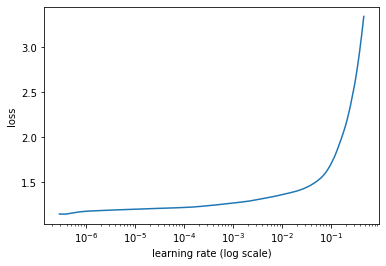

In [42]:
learner.lr_find(show_plot = True,max_epochs=1)